If the plots are displayed, either take a leap of faith and click the `Not Trusted` button on the top right to trust the embedded java-script, or execute the notebook again.

# RF-Pulse Simulation
The following code replicates the RF-pulse simulation of Fig. 3 and plots the $z^s$-magnetization at the end of respective pulse.

For these simulations we need the following packages:

In [1]:
using MRIgeneralizedBloch
using QuadGK
using DifferentialEquations
using SpecialFunctions
using Plots
plotlyjs(ticks=:native);

and we simulate an isolated semi-solid spin pool with the following parameters:

In [2]:
α = π
TRF = exp.(range(log(2e-7), log(1e-1), length=100)) # s
ω1 = α ./ TRF # rad/s
ω0 = 0 # rad/s
R1 = 1 # 1/s
T2s = 10e-6 # s
z0 = [1] # initial z-magnetization
z_fun(p, t) = [1.0] # initialize history function (will be populated with an interpolation by the differential equation solver)
nothing #hide

Here, we simulate a π-pulse. Replace first line with `α = π/4` or `α = π/2` to simulate the other two rows of Fig. 3.

## Lorentzian lineshape
In this script, we simulate the three lineshapes separately, starting with the Lorentzian lineshape for which the Bloch model provides a ground truth.

### Bloch model
We can formulate the Bloch model as
$$
\partial_t \begin{pmatrix} x \\ y \\ z \\ 1 \end{pmatrix} = \begin{pmatrix}
-R_2 & -ω_0 & ω_1 & 0 \\
ω_0 & -R_2 & 0 & 0 \\
-ω_1 & 0 & -R_1 & R_1 \\
0 & 0 & 0 & 0
\end{pmatrix} \begin{pmatrix} x \\ y \\ z \\ 1 \end{pmatrix} ,
$$
where the matrix is the Hamiltonian of the Bloch model. For a constant $ω_0$ and $ω_1$, we can evaluate the Bloch model by taking the  matrix exponential of its Hamiltonian:

In [3]:
H(ω1, ω0, R2, R1) = [-R2 -ω0  ω1  0;
                      ω0 -R2   0  0;
                     -ω1   0 -R1 R1;
                       0   0   0  0]

z_Bloch = similar(TRF)
for i = 1:length(TRF)
    (_, _, z_Bloch[i], _)  = exp(H(ω1[i], ω0, 1 / T2s, R1) * TRF[i]) * [0; 0; 1; 1]
end

### Graham's spectral model
Graham's spectral model is derived by integrating over the lineshape multiplied by the spectral response function of the RF-pulse. This results in the RF-induced saturation rate `Rrf` that is used in an exponential model:

In [4]:
Rrf = @. ω1^2 * T2s * ((exp(-TRF / T2s) -1) * T2s + TRF) / TRF
z_Graham_spec_Lorentzian = @. (Rrf * exp(-TRF * (R1 + Rrf)) + R1) / (R1 + Rrf)
nothing #hide

### Graham's single frequency approximation
In the single frequency approximation, Graham assumes that the RF-pulse has only a single frequency, which reduces `Rrf` to

In [5]:
g_Lorentzian(ω0) = T2s / π ./ (1 .+ (T2s .* ω0).^2)
Rrf = @. π * ω1^2 * g_Lorentzian(ω0)
z_Graham_SF_approx_Lorentzian = @. (Rrf * exp(-TRF * (R1 + Rrf)) + R1) / (R1 + Rrf)
nothing #hide

where `g_Lorentzian(ω0)` denotes the Lorentzian lineshape.

### Sled's model
Sled's model is given by the ordinary differential equation (ODE)
$$
\partial_t z(t) = \left(-\pi \int_0^t G(t-τ) \omega_1(τ)^2 dτ \right) z(t)  + R_1 (1-z),
$$
where $G(t-τ)$ is the Green's function. The Hamiltonian of this ODE is implemented in `apply_hamiltonian_sled!` and can be solve the ODE solver of the [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) package:

In [6]:
z_Sled_Lorentzian = similar(TRF)
for i = 1:length(TRF)
    z_Sled_Lorentzian[i] = solve(ODEProblem(apply_hamiltonian_sled!, z0, (0, TRF[i]), (ω1[i], 1, ω0, R1, T2s, greens_lorentzian)), Tsit5())[end][1]
end
nothing #hide

### generalized Bloch model
The generalized Bloch model is given by the intgro-differential equation (IDE)
$$
\partial_t z(t) = - ω_y(t) \int_0^t G(t,τ) ω_y(τ) z(τ) dτ - ω_x(t) \int_0^t G(t,τ) ω_x(τ) z(τ) dτ + R_1 (1 - z(t)) ,
$$
where we explicitly denote the $ω_x$ and $ω_y$ components of the Rabi frequency. The Hamiltonian of the IDE is implemented in `apply_hamiltonian_gbloch!` and we can solve this IDE with the [delay-differential equation (DDE)](https://diffeq.sciml.ai/stable/tutorials/dde_example/) solver of the [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) package:

In [7]:
z_gBloch_Lorentzian = similar(TRF)
for i = 1:length(TRF)
    z_gBloch_Lorentzian[i] = solve(DDEProblem(apply_hamiltonian_gbloch!, z0, z_fun, (0, TRF[i]), (ω1[i], 1, ω0, R1, T2s, greens_lorentzian)), MethodOfSteps(DP8()))[end][1]
end

Now we have solved all five models and can plot the solutions for comparison:

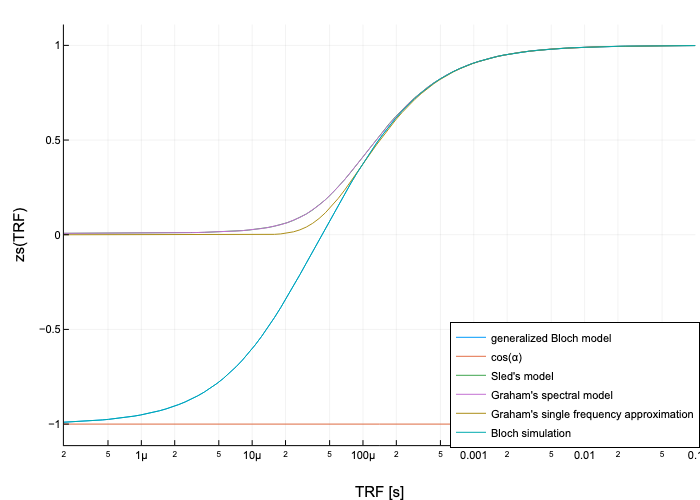

In [8]:
p = plot(xaxis=:log, legend=:bottomright, xlabel="TRF [s]", ylabel="zs(TRF)")
plot!(p, TRF, z_gBloch_Lorentzian, label="generalized Bloch model")
plot!(p, TRF, TRF .* 0 .+ cos(α), label="cos(α)")
plot!(p, TRF, z_Sled_Lorentzian, label="Sled's model")
plot!(p, TRF, z_Graham_spec_Lorentzian, label="Graham's spectral model")
plot!(p, TRF, z_Graham_SF_approx_Lorentzian, label="Graham's single frequency approximation")
plot!(p, TRF, z_Bloch, label="Bloch simulation")

## Gaussian lineshape
We can repeat the same simulation (with the exception of the Bloch model) for the Gaussian lineshape:

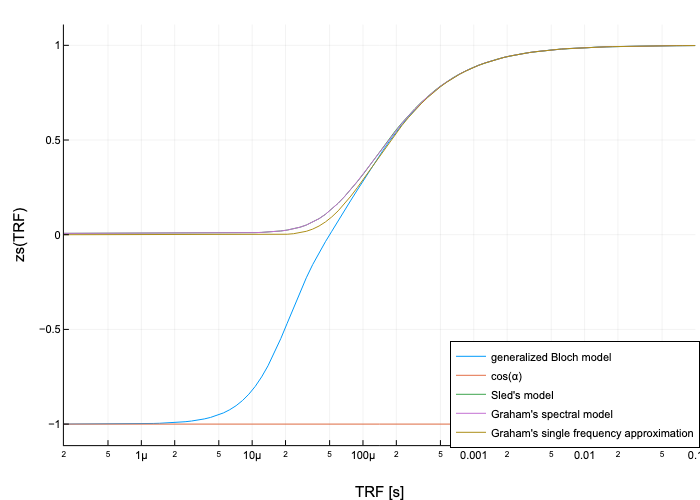

In [9]:
Rrf = @. ω1^2 * T2s * (2 * T2s * (exp(-(TRF/T2s)^2/2)-1) + sqrt(2π) * TRF * erf(TRF/T2s/sqrt(2))) / (2 * TRF)
z_Graham_spec_Gaussian = @. (Rrf * exp(-TRF * (R1 + Rrf)) + R1) / (R1 + Rrf)

g_Gaussian(ω0) = T2s / sqrt(2π) * exp(-(T2s * ω0)^2 / 2) # lineshape
Rrf = @. π * ω1^2 * g_Gaussian(ω0)
z_Graham_SF_approx_Gaussian = @. (Rrf * exp(-TRF * (R1 + Rrf)) + R1) / (R1 + Rrf)

z_Sled_Gaussian = similar(TRF)
for i = 1:length(TRF)
    z_Sled_Gaussian[i] = solve(ODEProblem(apply_hamiltonian_sled!, z0, (0, TRF[i]), (ω1[i], 1, ω0, R1, T2s, greens_gaussian)), Tsit5())[end][1]
end

z_gBloch_Gaussian = similar(TRF)
for i = 1:length(TRF)
    z_gBloch_Gaussian[i] = solve(DDEProblem(apply_hamiltonian_gbloch!, z0, z_fun, (0, TRF[i]), (ω1[i], 1, ω0, R1, T2s, greens_gaussian)), MethodOfSteps(DP8()))[end][1]
end

p = plot(xaxis=:log, legend=:bottomright, xlabel="TRF [s]", ylabel="zs(TRF)")
plot!(p, TRF, z_gBloch_Gaussian, label="generalized Bloch model")
plot!(p, TRF, TRF .* 0 .+ cos(α), label="cos(α)")
plot!(p, TRF, z_Sled_Gaussian, label="Sled's model")
plot!(p, TRF, z_Graham_spec_Gaussian, label="Graham's spectral model")
plot!(p, TRF, z_Graham_SF_approx_Gaussian, label="Graham's single frequency approximation")

## super-Lorentzian lineshape
Further, we can repeat the same simulation for the super-Lorentzian lineshape with the exception of Graham's single frequency approximation, as the super-Lorentzian lineshape diverges at $ω_0 → 0$.

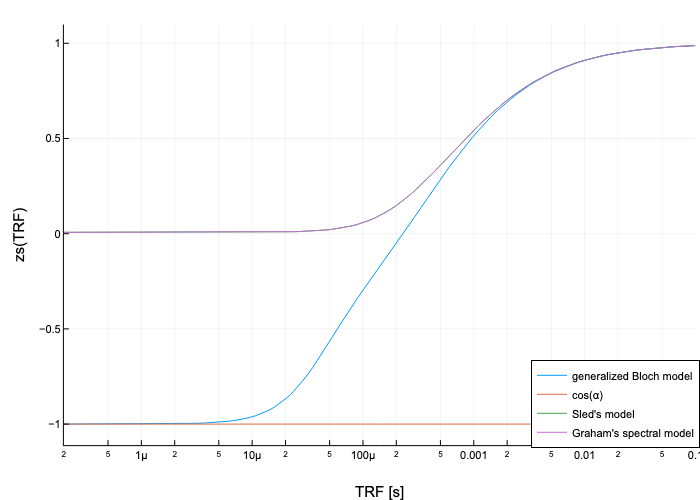

In [10]:
G_superLorentzian = interpolate_greens_function(greens_superlorentzian, 0, maximum(TRF)/T2s)

f_PSD(τ) = quadgk(ct -> (4 / τ / abs(1 - 3 * ct^2) * (exp(- τ^2 / 8 * (1 - 3 * ct^2)^2) - 1) + sqrt(2π) * erf(τ / 2 / sqrt(2) * abs(1 - 3 * ct^2))) / abs(1 - 3 * ct^2), 0.0, 1.0)[1]
Rrf = @. f_PSD(TRF / T2s) * ω1^2 * T2s
z_Graham_spec_superLorentzian = @. (Rrf * exp(-TRF * (R1 + Rrf)) + R1) / (R1 + Rrf)

z_Sled_superLorentzian = similar(TRF)
for i = 1:length(TRF)
    z_Sled_superLorentzian[i] = solve(ODEProblem(apply_hamiltonian_sled!, z0, (0, TRF[i]), (ω1[i], 1, ω0, R1, T2s, G_superLorentzian)), Tsit5())[end][1]
end

z_gBloch_superLorentzian = similar(TRF)
for i = 1:length(TRF)
    z_gBloch_superLorentzian[i] = solve(DDEProblem(apply_hamiltonian_gbloch!, z0, z_fun, (0, TRF[i]), (ω1[i], 1, ω0, R1, T2s, G_superLorentzian)), MethodOfSteps(DP8()))[end][1]
end

p = plot(xaxis=:log, legend=:bottomright, xlabel="TRF [s]", ylabel="zs(TRF)")
plot!(p, TRF, z_gBloch_superLorentzian, label="generalized Bloch model")
plot!(p, TRF, TRF .* 0 .+ cos(α), label="cos(α)")
plot!(p, TRF, z_Sled_superLorentzian, label="Sled's model")
plot!(p, TRF, z_Graham_spec_superLorentzian, label="Graham's spectral model")

This simulation reveals the most pronounced deviations of the generalized Bloch model from established models due to the slower decay of the super-Lorentzian Green's function.

### Error analysis
Assuming a super-Lorentzian lineshape, we quantify the deviations of Sled's model from the generalized Bloch model:

In [11]:
TRF_i = 1e-3 # s
ω1_i = α / TRF_i # rad/s
z_Sled_superLorentzian_i = solve(ODEProblem(apply_hamiltonian_sled!, z0, (0, TRF_i), (ω1_i, 1, ω0, R1, T2s, G_superLorentzian)), Tsit5())[end][1]
z_gBloch_superLorentzian_i = solve(DDEProblem(apply_hamiltonian_gbloch!, z0, z_fun, (0, TRF_i), (ω1_i, 1, ω0, R1, T2s, G_superLorentzian)), MethodOfSteps(DP8()))[end][1]
z_Sled_superLorentzian_i - z_gBloch_superLorentzian_i

0.02902263558937479

For $T_{\text{RF}} = 1$ms, the deviations are small compared to the thermal equilibrium magnetization $z^s_0 = 1$, but with $T_{\text{RF}} = 0.1$ms, this deviation becomes sizable:

In [12]:
TRF_i = 1e-4 # s
ω1_i = α / TRF_i # rad/s
z_Sled_superLorentzian_i = solve(ODEProblem(apply_hamiltonian_sled!, z0, (0, TRF_i), (ω1_i, 1, ω0, R1, T2s, G_superLorentzian)), Tsit5())[end][1]
z_gBloch_superLorentzian_i = solve(DDEProblem(apply_hamiltonian_gbloch!, z0, z_fun, (0, TRF_i), (ω1_i, 1, ω0, R1, T2s, G_superLorentzian)), MethodOfSteps(DP8()))[end][1]
z_Sled_superLorentzian_i - z_gBloch_superLorentzian_i

0.35494566805240374

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*